In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import datetime as dt
import glob2
print (tf.__version__)
!ls

2.2.0
sample_data


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:

! ls drive/'My Drive'/'Colab Notebooks'
! unzip drive/'My Drive'/'Colab Notebooks'/dataset.zip
! mv dataset/ food_data

Streaming output truncated to the last 5000 lines.
  inflating: dataset/training/food/1_840.jpg  
  inflating: dataset/training/food/1_1036.jpg  
  inflating: dataset/training/food/1_313.jpg  
  inflating: dataset/training/food/1_1331.jpg  
  inflating: dataset/training/food/1_758.jpg  
  inflating: dataset/training/food/1_204.jpg  
  inflating: dataset/training/food/1_1099.jpg  
  inflating: dataset/training/food/1_388.jpg  
  inflating: dataset/training/food/1_294.jpg  
  inflating: dataset/training/food/1_459.jpg  
  inflating: dataset/training/food/1_1468.jpg  
  inflating: dataset/training/food/1_1140.jpg  
  inflating: dataset/training/food/1_1225.jpg  
  inflating: dataset/training/food/1_1256.jpg  
  inflating: dataset/training/food/1_33.jpg  
  inflating: dataset/training/food/1_42.jpg  
  inflating: dataset/training/food/1_175.jpg  
  inflating: dataset/training/food/1_246.jpg  
  inflating: dataset/training/food/1_707.jpg  
  inflating: dataset/training/food/1_100.jpg  
  in

In [8]:
image_train = [img_path for img_path in glob2.glob("food_data/training/*/*.jpg") if 'jpg' in img_path] 
print ("trainig imges",len(image_train))
img_test =[img_path for img_path in glob2.glob("food_data/validation/*/*.jpg") if 'jpg' in img_path] 
print ("test images",len(img_test))


trainig imges 3000
test images 1000
evaluation images 1000


In [10]:
cls_dict = dict()
CLASS_NAMES = np.array([cls.split('/')[-1] for cls in glob2.glob('food_data/training/*')])
print (CLASS_NAMES)
NUM_CLASS = len(CLASS_NAMES)
for i , cls in enumerate(CLASS_NAMES):
  cls_dict[i] = cls 
print (cls_dict)
print (NUM_CLASS)

['non_food' 'food']
{0: 'non_food', 1: 'food'}
2


In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
EPOCHS = 10
INIT_LR = 1e-3

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# since we are going to use Resnet for feaure extraction but not necessary 
from tensorflow.keras.applications.resnet50 import preprocess_input
data = []
labels = []
def get_label(image_path):
  parts= tf.strings.split(image_path,sep='/')
  cls_name = parts[-2]
  for key,value in cls_dict.items():
    if cls_name == value:
      return key

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float16)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

for image_path in list(glob2.glob("food_data/training/*/*.jpg")):
  # image_path = os.fspath(image_path)
  label = get_label(image_path)
  
  img = tf.io.read_file(image_path)
  img = decode_img(img)
  #img = preprocess_input(img.numpy())
  
  data.append(img.numpy())
  labels.append(label)



In [15]:
Y = np.asarray(labels)
print(Y.shape)
X = np.asarray(data)
print (X.shape)

(3000,)
(3000, 224, 224, 3)


In [0]:
# print(X[:2])
# print (Y[:2])

In [14]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
lb = LabelBinarizer()
print(Y)
labels_embedding = lb.fit_transform(Y) # one hot encoding
print(labels_embedding)

[0 0 0 ... 1 1 1]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [18]:
(trainX, testX, trainY, testY) = train_test_split(X, labels_embedding,test_size=0.10, stratify=labels, random_state=42)
print(trainX.shape)
print(trainY.shape)
print (testX.shape)
print (testY.shape)

(2700, 224, 224, 3)
(2700, 1)
(300, 224, 224, 3)
(300, 1)


In [0]:
from  tensorflow.keras.preprocessing import image
datagen = image.ImageDataGenerator(
    featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(-5,5))
datagen.fit(trainX)

In [20]:
# https://keras.io/api/applications/
from tensorflow.keras.applications import ResNet50
# Pre-trained model with RESNET
base_model = ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')
dense_layer = tf.keras.layers.Dense(128, activation='linear')
base_model = tf.keras.Sequential([
    base_model,
    dense_layer]
)
base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 128)         262272    
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
from sklearn.utils import shuffle
Xtrain,Y_train = shuffle(trainX,trainY)
!mkdir saved_model
base_model.save('saved_model/Resnet_fetExtract.h5')

In [0]:
# We use Keras Feature extraction Technique to extract features from the images 
features = base_model.predict(Xtrain,batch_size=BATCH_SIZE)



In [23]:
features  = features.reshape (features.shape[0],7*7*128)
print(features.shape)

(2700, 6272)


In [30]:
import joblib
joblib.dump([Y_train,features],'bof_fooddata.bz2')

['bof_fooddata.bz2']

In [31]:
!ls
# once this file is generated it contatins the features  and labels 

bof_fooddata.bz2  drive  food_data  sample_data  saved_model


In [40]:
import joblib
import numpy as np
import pandas as pd
labels , features = joblib.load('bof_fooddata.bz2')
print (labels.shape)
print(features.shape)
print(features[5])

(2700, 1)
(2700, 6272)
[ 0.09509303  0.2828659   0.5855963  ... -0.7370825   1.1024381
 -0.86957484]


In [41]:
# once we have features from the model we can use any ML tecnique to identiy the class 
labels = np.ravel(labels)
labels

array([1, 1, 1, ..., 0, 1, 0])

In [42]:
import numpy as np
import pandas as pd
!pip install tpot
from tpot import TPOTClassifier
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [43]:
X_train, X_test, y_train, y_test = train_test_split(features,labels, train_size=0.5,test_size=0.03,)
print ("Trainnig data",X_train.shape)
print ("Train label",y_train.shape)
print ("Test data",X_test.shape)
print ("Test Label",y_test.shape)

Trainnig data (1350, 6272)
Train label (1350,)
Test data (81, 6272)
Test Label (81,)


In [44]:
import gc
gc.collect()

1078

In [45]:
tpot = TPOTClassifier(generations=3,verbosity=2,cv=3,random_state=42)
tpot.fit(X_train,y_train)



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GaussianNB(input_matrix)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=3,
               disable_update_check=False, early_stop=None, generations=3,
               log_file=<ipykernel.iostream.OutStream object at 0x7fcedf938c88>,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=42, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [52]:
print(tpot.score(X_test, y_test))
results = tpot.predict(X_test)

0.7407407407407407


In [53]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,roc_curve,roc_auc_score,auc

rfc_pred = pd.DataFrame({'Target_status':y_test,'inference':results})
# Let's check the report of our default model
print ("ROC-AUC Score= {:2.2}".format(roc_auc_score(rfc_pred.Target_status, rfc_pred.inference)))
print ("Accuracy score= {:2.2}".format(accuracy_score(rfc_pred.Target_status, rfc_pred.inference)))
confusion = confusion_matrix(rfc_pred.Target_status,rfc_pred.inference)
print ("Confusion Matrix \n{}".format(confusion))
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
print("TP",TP) 
print("TN",TN) 
print("FP",FP) 
print("FN",FN)
print ("Recall= {}".format(TP/float(TP+FN)))
print ("Precison= {}".format(TP/float(TP+FP)))
print ("specificity= {}".format(TN / float(TN+FP)))

ROC-AUC Score= 0.74
Accuracy score= 0.74
Confusion Matrix 
[[35 12]
 [ 9 25]]
TP 25
TN 35
FP 12
FN 9
Recall= 0.7352941176470589
Precison= 0.6756756756756757
specificity= 0.7446808510638298


In [0]:
#tpot.export('tpot_exported_pipeline_fooddataset.py')

In [54]:
!ls

bof_fooddata.bz2  drive  food_data  sample_data  saved_model


In [0]:
#from exported pipeline 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [0]:
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, labels, random_state=42)

In [0]:
# Average CV score on the training set was: 0.7525925925925926
exported_pipeline = GaussianNB()
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [58]:
exported_pipeline.score(testing_features,testing_target)

0.7570370370370371

In [59]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,roc_curve,roc_auc_score,auc

rfc_pred = pd.DataFrame({'Target_status':testing_target,'inference':results})
# Let's check the report of our default model
print ("ROC-AUC Score= {:2.2}".format(roc_auc_score(rfc_pred.Target_status, rfc_pred.inference)))
print ("Accuracy score= {:2.2}".format(accuracy_score(rfc_pred.Target_status, rfc_pred.inference)))
confusion = confusion_matrix(rfc_pred.Target_status,rfc_pred.inference)
print ("Confusion Matrix \n{}".format(confusion))
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
print("TP",TP) 
print("TN",TN) 
print("FP",FP) 
print("FN",FN)
print ("Recall= {}".format(TP/float(TP+FN)))
print ("Precison= {}".format(TP/float(TP+FP)))
print ("specificity= {}".format(TN / float(TN+FP)))

ROC-AUC Score= 0.76
Accuracy score= 0.76
Confusion Matrix 
[[265  80]
 [ 84 246]]
TP 246
TN 265
FP 80
FN 84
Recall= 0.7454545454545455
Precison= 0.754601226993865
specificity= 0.7681159420289855


In [60]:
print(classification_report(testing_target,results)) # only for Binary classification

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       345
           1       0.75      0.75      0.75       330

    accuracy                           0.76       675
   macro avg       0.76      0.76      0.76       675
weighted avg       0.76      0.76      0.76       675



In [115]:
# Testing the ML model over Evaluation Dataset , never seen by the algorithm 
import glob2 as glob
import tensorflow as tf
img_eval = [img_path for img_path in glob.glob("food_data/evaluation/*/*.jpg") if 'jpg' in img_path] 
print ("evaluation images",len(img_eval))


evaluation images 1000


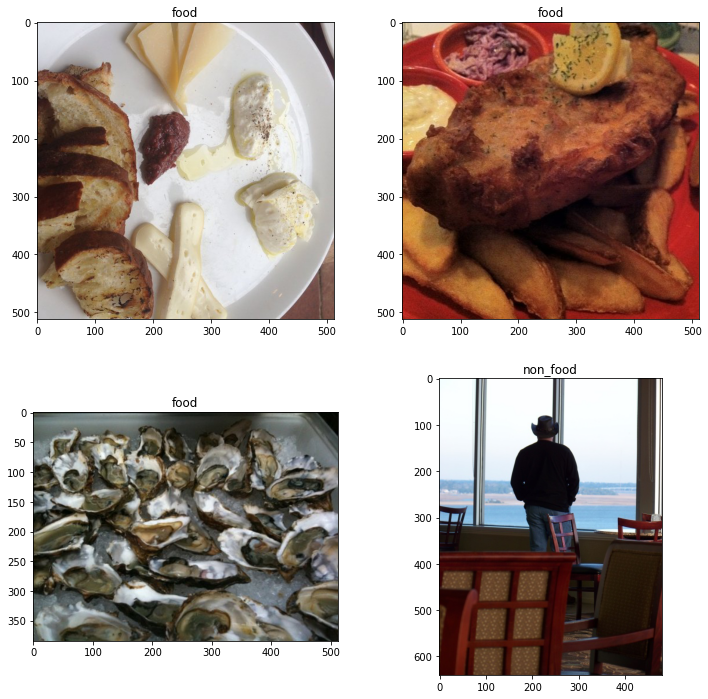

In [116]:
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
img_eval = shuffle(img_eval)
_, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
for imgpath, ax in zip(img_eval, axs):
    img = Image.open(imgpath)
    ax.set_title(imgpath.split('/')[-2])
    ax.imshow(img,)
    #ax.set_label()
plt.show()

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [0]:
data = []
test_labels = []
img_info =[]
def get_label(image_path):
  parts= tf.strings.split(image_path,sep='/')
  cls_name = parts[-2]
  for key,value in cls_dict.items():
    if cls_name == value:
      return key

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float16)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

for image_path in list(glob2.glob("food_data/evaluation/*/*.jpg")):
  # image_path = os.fspath(image_path)
  label = get_label(image_path)
  img = tf.io.read_file(image_path)
  img = decode_img(img)
  #img = preprocess_input(img.numpy())
  data.append(img.numpy())
  test_labels.append(label)
  img_info.append(image_path)

test_labels = np.asarray(test_labels)
data = np.asarray(data)



In [119]:
print (test_labels.shape)
print(data.shape)

(1000,)
(1000, 224, 224, 3)


In [120]:
from tensorflow.keras.models import load_model
fet_extract = load_model('/content/saved_model/Resnet_fetExtract.h5')

In [121]:
test_fet = fet_extract.predict(data,batch_size=BATCH_SIZE)
test_fet = test_fet.reshape(test_fet.shape[0],7*7*128)
test_fet.shape

(1000, 6272)

In [0]:
predictions = exported_pipeline.predict(test_fet)
exported_pipeline.score(test_fet,test_labels)
predictions = [cls_dict[val] for val in predictions]
test_labels = [cls_dict[val]for val in test_labels]


In [123]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,roc_curve,roc_auc_score,auc
cls_dict = {0:'non-food',1:'food'}
rfc_eval = pd.DataFrame({'ImagePath':img_info,'Target_status':test_labels,'inference':predictions})
# # Let's check the report of our default model
print ("ROC-AUC Score= {:2.2}".format(roc_auc_score(rfc_pred.Target_status, rfc_pred.inference)))
print ("Accuracy score= {:2.2}".format(accuracy_score(rfc_pred.Target_status, rfc_pred.inference)))

ROC-AUC Score= 0.76
Accuracy score= 0.76


In [124]:
rfc_eval

,ImagePath,Target_status,inference
0,food_data/evaluation/non_food/0_396.jpg,non_food,food
1,food_data/evaluation/non_food/0_263.jpg,non_food,non_food
2,food_data/evaluation/non_food/0_41.jpg,non_food,non_food
3,food_data/evaluation/non_food/0_365.jpg,non_food,non_food
4,food_data/evaluation/non_food/0_429.jpg,non_food,non_food
...,...,...,...
995,food_data/evaluation/food/1_191.jpg,food,food
996,food_data/evaluation/food/1_99.jpg,food,non_food
997,food_data/evaluation/food/1_27.jpg,food,food
998,food_data/evaluation/food/1_98.jpg,food,food
